# Convolutions

We have gone form scalar-valued computational graphs to tensor-valued ones and gained efficiency through using larger blocks of computation.
For signals with spatial information (e.g. sequences (1D), images (2D), volume images or videos (3D)), a full MLP will be prohibitively expensive. For a $512 \times 512 \times 3$ color image we would need a matrix of size $512^2\cdot 3 \times d_{hidden}$, where $d_hidden$ is the hidden dimension, which will be infeasible for high values of $d_{hidden}$ that will allow good performance.

Convolutions solve this problem by parametrizing small kernels that slide over the signal and compute large number of hidden features. Reasons for their performance are
- inductive bias: Convolutions use spatial equivariance: If we shift the input by some offset, the output is shifted correspondingly. This allows for faster training, since this reasonable NN behaviour need not be trained anymore.
- Parameter sharing: Convolutions use the same kernel for multiple signal/image locations, reducing the computational complexity of the model.


In [268]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [269]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
from Tensor import Tensor

# Convolution implementation

For later usage consistent with PyTorch, we will use the format `C x H x W` for input image subsequent latent representations, where
- `C` is the number of channels (e.g. 3 for input color images and arbitrary numbers for hidden feature dimension in later layers),
- `H` is the signal height and
- `W` its width.

When a channel dimension is not mentioned as in the examples below, we may implicitly assume that the signal is of the format `H x W`.

First, we will need for usage later a `__getitem__` dunder to select part of the input and backprop through it.

In [271]:
def __getitem__(self, idx):
    out_data = self.data[idx]
    out = Tensor(data=out_data, children=(self,), requires_grad=self._requires_grad, label="getitem")

    def _backward():
        self.grad[idx] += out.grad

    out._backward = _backward
    return out

Next, we need a padding function that will extend the image by a specified number of pixels.

In [272]:
def pad2d(self, padding:int):
    assert padding > 0
    assert len(self.data.shape) >= 2
    pad_shape = list(self.data.shape)
    for i in [-1,-2]:
        pad_shape[i] += 2*padding
    out_data = np.zeros(pad_shape)
    out_data[:,padding:-padding, padding:-padding] = self.data
    out = Tensor(data=out_data, children=(self,), operation="pad")

    def _backward():
        self.grad += out.grad[:,padding:-padding, padding:-padding]

    out._backward = _backward
    return out

## Convolution definition

Convolutions work on
- an input signal $x \in \mathbb{R}^{H \times W}$ and
- a kernel $k \in \mathbb{R}^{2k+1 \times 2k+1}$ of kernel width $k \geq 0$.

For two-dimensional convolution the kernel will slide over a padded image and compute the inner product at hte overlapping portion.
This can be naively implemented as

$$
(x * k)(i, j) = \sum_{m=-k}^{k} \sum_{n=-k}^{k} x(i+m, j+n) \cdot k(m, n)
$$

and looping over each pixel coordinate $i,j$.

### Filter response and boundary treatment

![Convolution on padded image: Filter response](https://upload.wikimedia.org/wikipedia/commons/b/bd/Convolutional_neural_network%2C_convolution_worked_example.png)

### Sliding window

![Sliding window for convolution](https://www.researchgate.net/profile/Linghao-Song/publication/325866451/figure/fig1/AS:643640896520193@1530467356955/Two-levels-of-sliding-windows-in-2D-convolution.png)

### Convolution implementation

In python looping over each pixel coordinate would not lead to efficient code, since 
- loops with small loop bodies incur large overhead
- the computational graph would be on the order of the image size $n \times m$.

A more efficient implementation is as follows:
- We iterate over each kernel coordinate (of which $(2k + 1) \times (2k+1)$ exist).
- For each kernel coordinate, we multiply the whole input image with the corresponding kernel entry.
- Sum up all kernel responses appropriately shifted.

In [273]:
def conv2d(self, kernel, padding = None):
    # apply kernel to image, return image of the same shape
    k = kernel.data.shape[-1]
    if padding is None:
        padding = k // 2
    # place the image inside a frame to compensate for the kernel overlap
    a = self.pad2d(padding)
    out_shape = [self.data.shape[0], self.data.shape[1]]
    b = Tensor(data=np.zeros(out_shape), children=(self, kernel), requires_grad=True)
    # shift the image around each pixel, multiply by the corresponding kernel value and accumulate the results
    for i in range(k):
        for j in range(k):
            di, dj = i + self.data.shape[-2], j + self.data.shape[-1]
            b += a[i:di, j:dj] * kernel[i, j]
    return b


/var/folders/_c/2xdgy4gd32z78rxdjrpqtngr0000gn/T/ipykernel_65370/1572060900.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  lena = imageio.imread(url)


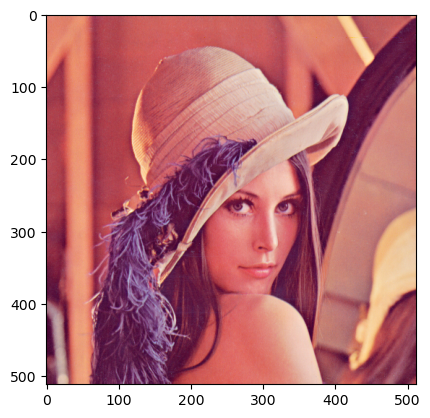

In [274]:
# Test image for 2D convolution
import imageio
url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
lena = imageio.imread(url)

plt.imshow(lena)

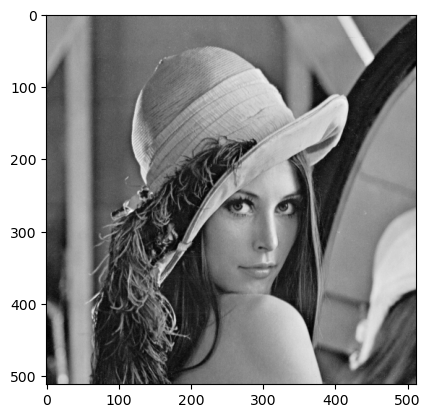

In [275]:
from PIL import Image

# make gray-scale image
lena_bw = Image.fromarray(lena).convert('L')
plt.imshow(lena_bw, cmap='gray')


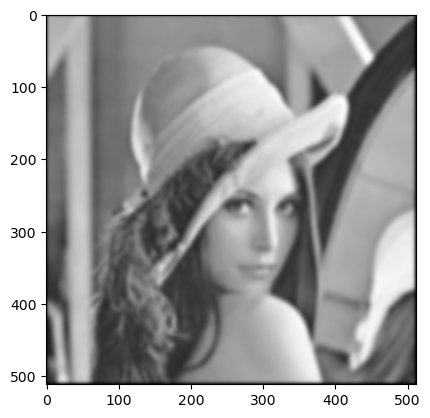

In [276]:
# Apply 2D-convolution for smoothing gray image

# Add one more dimension (channel) to the image -> will be used later on for multi-channel images
lena_np = np.array(lena_bw).astype(np.float32) / 255.0
lena_tensor = Tensor(data=lena_np)

smoothing_kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).astype(np.float32) / 9
smoothing_kernel = Tensor(data=smoothing_kernel)

lena_smooth = lena_tensor
for iter in range(13):
    lena_smooth = lena_smooth.conv2d(smoothing_kernel, padding=1)

plt.imshow(Image.fromarray(np.squeeze(255*lena_smooth.data).astype(np.uint8)), cmap='gray')

### Convolution on multi-channel input

When we have a color image, each convolution kernel needs to be of size $c \times (2k+1)^2$ to enable computations across channels.
For each image position, we will have $c$ values.
Instead of a single scalar multiplication for each pixel value, we will compute an inner product between the $c$ image values and the $c$ kernel responses at that location.

In the inner loop replace the line

`b += a[i:di, j:dj] * kernel[i, j]`

by

`b += einsum("cij,c->ij", a[:,i:di, j:dj], kernel[:,i, j])`

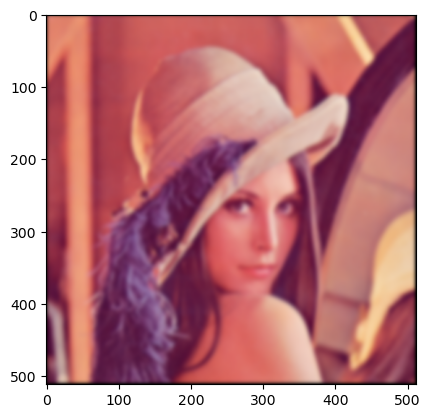

In [277]:
# Apply 2D-convolution for smoothing: color image
# Convert to C x H x W format used in pytorch and tensorgrad
lena_normalized = (lena.astype(np.float32) / 255.0).transpose(2, 0, 1)

# three kernels: smooth each color channel independently
#smoothing_kernel = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # identity kernel
smoothing_kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).astype(np.float32) / 9
empty_kernel = np.zeros_like(smoothing_kernel)

smoothing_kernel_1 = np.stack([smoothing_kernel, empty_kernel, empty_kernel])
smoothing_kernel_1 = Tensor(data=smoothing_kernel_1)

smoothing_kernel_2 = np.stack([empty_kernel, smoothing_kernel, empty_kernel])
smoothing_kernel_2 = Tensor(data=smoothing_kernel_2)

smoothing_kernel_3 = np.stack([empty_kernel, empty_kernel, smoothing_kernel])
smoothing_kernel_3 = Tensor(data=smoothing_kernel_3)

lena_smooth = Tensor(data=lena_normalized)
for iter in range(13):
    lena_smooth_1 = lena_smooth.conv2d(smoothing_kernel_1, padding=1)
    lena_smooth_2 = lena_smooth.conv2d(smoothing_kernel_2, padding=1)
    lena_smooth_3 = lena_smooth.conv2d(smoothing_kernel_3, padding=1)
    lena_smooth = np.stack([lena_smooth_1.data, lena_smooth_2.data, lena_smooth_3.data])
    lena_smooth = Tensor(data=lena_smooth)

lena_smooth_img = Image.fromarray((255*lena_smooth.data).astype(np.uint8).transpose(1, 2, 0))
plt.imshow(lena_smooth_img)

## Multiple channel-input and -output 2D-convolution

If we had multiple output channels, the above code will not be elegant and efficient: we would have to loop over separate kernels for each output dimension.
In the multiple output channel scenario, a more elegant way is to have kernels of size $c_{out} \times c_{in} \times (2k+1)^2$

where
- $c_{in}$ is the number of input channels
- $c_{out}$ is the number of output channels.

### Example: 2 input channel, two output channel 1x1 convolution

![Multiple channel 1x1 convolution](http://d2l.ai/_images/conv-multi-in.svg)

In the inner loop of our 2D-convolution we replace the inner product

`b += einsum("cij,c->ij", a[:,i:di, j:dj] * kernel[:,i, j])`

by a matrix multiplication

`b += einsum("cij,cd->dij", a[:,i:di, j:dj] * kernel[:,:,i, j])`


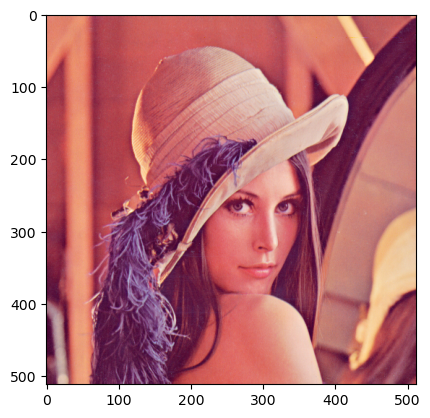

In [278]:
# Apply 2D-convolution for smoothing: color image
# Convert to C x H x W format used in pytorch and tensorgrad
lena_normalized = (lena.astype(np.float32) / 255.0).transpose(2, 0, 1)

# identity kernel
id_kernel = np.zeros((3,3,3,3))
for i in range(3):
    id_kernel[i,i,1,1] = 1.0
id_kernel = Tensor(data=id_kernel)

lena_id = Tensor(data=lena_normalized).conv2d(id_kernel, padding=1)

lena_id_img = Image.fromarray((255*lena_id.data).astype(np.uint8).transpose(1, 2, 0))
plt.imshow(lena_id_img)

0.48404450778080144


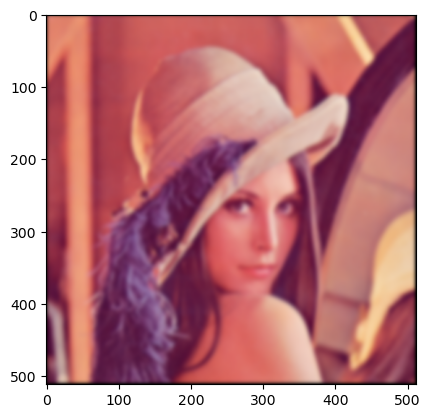

In [279]:
# now do smoothing with one kernel
lena_normalized = (lena.astype(np.float32) / 255.0).transpose(2, 0, 1)

smoothing_kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).astype(np.float32) / 9
empty_kernel = np.zeros_like(smoothing_kernel)

smoothing_kernel_1 = np.stack([smoothing_kernel, empty_kernel, empty_kernel])
smoothing_kernel_2 = np.stack([empty_kernel, smoothing_kernel, empty_kernel])
smoothing_kernel_3 = np.stack([empty_kernel, empty_kernel, smoothing_kernel])

smoothing_kernel = np.stack([smoothing_kernel_1, smoothing_kernel_2, smoothing_kernel_3], axis=0)
smoothing_kernel = Tensor(data=smoothing_kernel)

lena_smooth = Tensor(data=lena_normalized)
for i in range(13):
    lena_smooth = lena_smooth.conv2d(smoothing_kernel, padding=1)

print(np.max(lena_smooth.data - lena_normalized) )

lena_smooth_img = Image.fromarray((255*lena_smooth.data).astype(np.uint8).transpose(1, 2, 0))
plt.imshow(lena_smooth_img)

# Pooling

If we naively do convolution, the spatial image resolution will not change. For good performance, though, we will typically need a larger number of channels.
Such a neural network is prohibitively expensive to compute, though, if we do not downsample with regard to the spatial dimensions.
In order to mitigate this computational burden, we will down-scale spatial resolution of the intermediate activations.
This is typically done in two ways:
- convolutions with stride > 1 (exercise)
- pooling (max or average)

In pooling, we will take a covering of the image grid by a sliding subwindow and aggregate values in each subwindow

![2x2 Max-Pooling](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

In [280]:
def max_pool(self, kernel_size: int = 2):
    n,m = self.data.shape[-2], self.data.shape[-1]
    assert n % kernel_size == 0 # for images not divisible by kernel_size one would have to pad
    assert m % kernel_size == 0

    ny = m // kernel_size
    nx = n // kernel_size

    new_shape = (-1, ny,kernel_size,nx,kernel_size)
    out_data = np.max(self.data.reshape(new_shape),axis=(2,4))

    return Tensor(data=out_data, children=(self,), operation="max-pool")

In [281]:
# Test on random 4x4 image
x = np.random.randn(1,4,4)
print(x)
x = Tensor(data=x)
y = max_pool(x, 2)
print(y.data)

[[[-2.4368279  -0.88382821 -0.57800028  1.88819188]
  [ 0.72984501  0.00947962  1.34594151 -1.17747846]
  [ 0.38626809 -0.47322252  0.88084852  0.56683459]
  [ 0.01742304  0.26131309  0.75765268 -0.50927489]]]
[[[0.72984501 1.88819188]
  [0.38626809 0.88084852]]]


## Flatten

After the last convolutional layer, we want to stack all down-sampled feature vectors on top of each other so that we get one feature vector for the whole image.

In [282]:
def flatten(self):
    out_data = self.data.flatten()
    out = Tensor(data=out_data, children=(self,), requires_grad=self._requires_grad, label="flatten")

    def _backward():
        self.grad += out.grad.reshape(self.data.shape)

    out._backward = _backward
    return out

# Convolutional Neural Network

A convolutional neural network will consist of multiple layers of convolutions with a non-linearity and pooling in between and a final MLP for computing as many outputs as needed.

![CNN architecture](https://saturncloud.io/images/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way.webp)

In [283]:
class CNN:
    def __init__(self, hidden_dims, kernel_widths, n_out:int):
        self.kernels = []
        for i in range(len(hidden_dims)-1):
            kernel_1 = np.random.uniform(low=-0.05, high=0.05, size=(hidden_dims[i+1], hidden_dims[i], kernel_widths[i], kernel_widths[i]))
            kernel_1 = Tensor(data=kernel_1, requires_grad=True)
            kernel_1._label = f"1st kernel in layer {i}"
            kernel_2 = np.random.uniform(low=-0.05, high=0.05, size=(hidden_dims[i+1], hidden_dims[i+1], kernel_widths[i], kernel_widths[i]))
            kernel_2 = Tensor(data=kernel_2, requires_grad=True)
            kernel_2._label = f"1st kernel in layer {i}"
            self.kernels.append([kernel_1, kernel_2])

        # since we are doing 28x28, 2x2 max pooling, and 2 convolutions, the final size is 7x7
        linear = np.random.uniform(low=-0.05, high=0.05, size=(n_out, 28*28*hidden_dims[-1]))
        linear = np.random.uniform(low=-0.05, high=0.05, size=(n_out, 7*7*hidden_dims[-1]))
        self.linear = Tensor(data=linear, requires_grad=True)

    def __call__(self, x):
        x = Tensor(data=x) if not isinstance(x, Tensor) else x
        for kernel_1, kernel_2 in self.kernels:
            x = x.conv2d(kernel_1)
            x = x.tanh()
            #x = x.conv2d(kernel_2)
            #x = x.relu()
            x = x.max_pool(kernel_size=2, stride=2)
        x = x.flatten()
        x = self.linear @ x
        x = x.softmax()
        return x

    def parameters(self):
        params = [self.linear]
        for kernel_1, kernel_2 in self.kernels:
            params.append(kernel_1)
            params.append(kernel_2)
        return params

In [284]:
model = CNN(hidden_dims=[1, 2, 4], kernel_widths=[3, 3], n_out=10)

# Test the model on random Fashion-MNIST image
x = np.expand_dims(X_train[i].reshape(28, 28), axis=0)
print(x.shape)

print(model(x).data)

(1, 28, 28)
[0.10006796 0.09997862 0.09999257 0.10005481 0.0999177  0.09998282
 0.10008667 0.09995864 0.09982743 0.10013279]


## Test on Fashion-MNIST 

Reload fashion-mnist

In [285]:
!git clone https://github.com/zalandoresearch/fashion-mnist

226077.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
fatal: destination path 'fashion-mnist' already exists and is not an empty directory.


In [286]:
# import Fashion-MNIST
import sys
import os

# Add the path to the utils directory
fashion_mnist_path = os.path.join(os.getcwd(), 'fashion-mnist')
sys.path.append(fashion_mnist_path)

from utils import mnist_reader

X_train, y_train = mnist_reader.load_mnist(os.path.join(fashion_mnist_path, 'data/fashion'), kind='train')
X_test, y_test = mnist_reader.load_mnist(os.path.join(fashion_mnist_path, 'data/fashion'), kind='t10k')

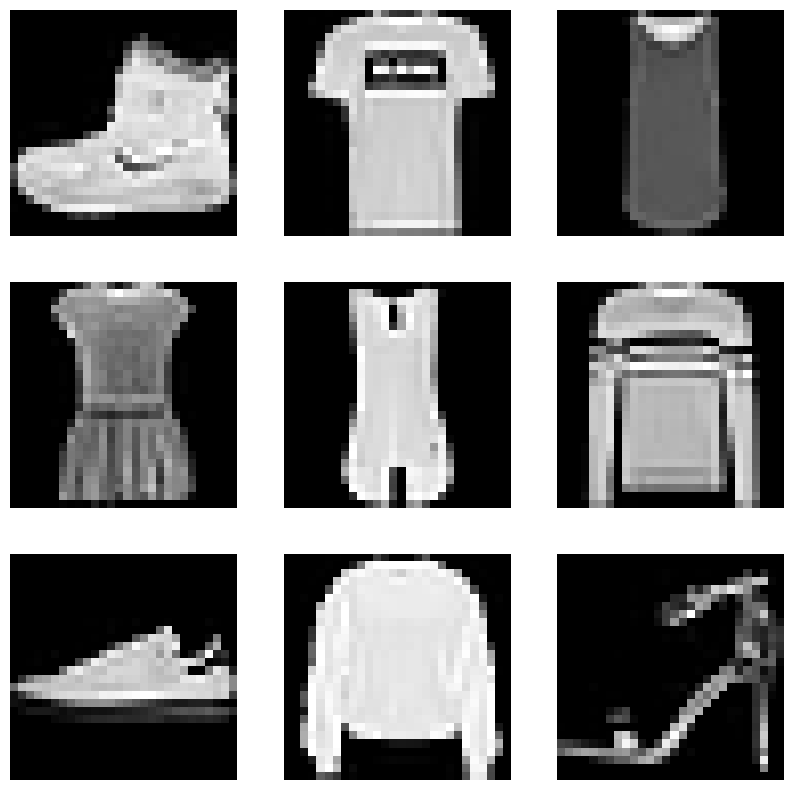

In [287]:
# Visualize the first 9 digites
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax = axs[i//3, i%3]
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')


In [288]:
# Normalize the input data:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
X_train /= 255.0
X_test /= 255.0

Train on Fashion-MNIST with mini-batch gradient descent exactly like the MLP in the previous notebook.

In [289]:
def validate(model, X_val, y_val):
    correct_predictions = 0
    total_predictions = 0

    for i in range(X_val.shape[0]):
        x = X_val[i]
        x = x.reshape(1, 28, 28)
        y_true = y_val[i]

        # Forward pass
        y_pred = model(x)

        # Get the predicted class (assuming y_pred is a Tensor with probabilities)
        predicted_class = np.argmax(y_pred.data)

        # Check if the prediction is correct
        if predicted_class == y_true:
            correct_predictions += 1

        total_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

In [290]:
# subsample training and val for faster execution
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]
X_train = X_train[:1000]
y_train = y_train[:1000]

val_indices = np.arange(X_test.shape[0])
np.random.shuffle(val_indices)
X_test = X_test[val_indices]
y_test = y_test[val_indices]
X_test = X_test[:100]
y_test = y_test[:100]

In [291]:
model = CNN(hidden_dims=[1, 2, 4], kernel_widths=[3, 3], n_out=10)

val_acc = validate(model, X_test, y_test)
print(f"Before training: validation accuracy: {val_acc}")

# Parameters
batch_size = 32
num_epochs = 50
lr = 0.1

# Training loop
losses = []
val_accs =[]
for epoch in range(num_epochs):
    # Shuffle the data at the beginning of each epoch
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]

    loss = 0.0

    for i in range(0, X_shuffled.shape[0], batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]

        # Forward pass
        preds = [model(x.reshape(1,28,28)) for x in X_batch]

        # Loss calculation
        mb_loss = [ypred.cross_entropy(ytrue) for ytrue, ypred in zip(y_batch, preds)]
        mb_loss = sum(mb_loss) / len(mb_loss)
        loss += mb_loss.data * X_batch.shape[0] / X_shuffled.shape[0]

        ### ZERO GRAD ###
        for p in model.parameters():
            p.grad *= 0.0

        # backward pass
        mb_loss.backward()

        # update
        for p in model.parameters():
            # The weight update
            p.data += -lr * p.grad

    losses.append(loss)
    val_acc = validate(model, X_test, y_test)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}, Loss: {loss}, validation accuracy: {val_acc}")

Before training: validation accuracy: 0.02
Epoch 0, Loss: 2.3016698209884527, validation accuracy: 0.12
Epoch 1, Loss: 2.284492611050852, validation accuracy: 0.23
Epoch 2, Loss: 1.8779715031558586, validation accuracy: 0.4
Epoch 3, Loss: 1.4030824270743982, validation accuracy: 0.45
Epoch 4, Loss: 1.1697997889804195, validation accuracy: 0.55
Epoch 5, Loss: 1.025752252298394, validation accuracy: 0.66
Epoch 6, Loss: 0.9061060626918394, validation accuracy: 0.46
Epoch 7, Loss: 0.8785959721243877, validation accuracy: 0.6
Epoch 8, Loss: 0.7928234434566614, validation accuracy: 0.65
Epoch 9, Loss: 0.729858805997783, validation accuracy: 0.79
Epoch 10, Loss: 0.6828357636211647, validation accuracy: 0.66
Epoch 11, Loss: 0.6652973379374351, validation accuracy: 0.76
Epoch 12, Loss: 0.6314038417154298, validation accuracy: 0.8
Epoch 13, Loss: 0.598599204578971, validation accuracy: 0.76
Epoch 14, Loss: 0.5960289925709809, validation accuracy: 0.79
Epoch 15, Loss: 0.5598869612149153, validati

# End of NP-hard part

This is it for the first NP-hard part of the lecture. We will switch to pytorch for the remainder but stay true to our goal of writing as much as possible from scratch. We will be able to go to larger models through pytorch (cuda and MPS) and get a few amenities to make life easier.